In [1]:
pip install datasets tensorflow opencv-python matplotlib pandas scikit-learn


In [2]:
from datasets import load_dataset
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
!git lfs install

Git LFS initialized.


In [6]:
!git clone https://huggingface.co/datasets/garythung/trashnet

Cloning into 'trashnet'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Unpacking objects: 100% (11/11), 1.97 KiB | 671.00 KiB/s, done.
Filtering content: 100% (2/2), 3.42 GiB | 32.40 MiB/s, done.


In [7]:
!unzip /content/trashnet/dataset-original.zip


Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/dataset-original/cardboard/._cardboard132.jpg  
  inflating: dataset-original/cardboard/cardboard133.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard133.jpg  
  inflating: dataset-original/cardboard/cardboard134.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard134.jpg  
  inflating: dataset-original/cardboard/cardboard135.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard135.jpg  
  inflating: dataset-original/cardboard/cardboard136.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard136.jpg  
  inflating: dataset-original/cardboard/cardboard137.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard137.jpg  
  inflating: dataset-original/cardboard/cardboard138.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard138.jpg  
  inflating: dataset-original/cardboard/cardboard139.jpg  
  inflating: __MACOSX/dataset-original/cardboa

In [9]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 128
DATASET_PATH = "/content/dataset-original"  # Change to your path

images = []
labels = []

print("[INFO] Loading and processing TrashNet dataset...")

def enhance_image(img):
    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Histogram equalization to improve contrast
    equalized = cv2.equalizeHist(gray)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(equalized, (3, 3), 0)

    # Optional: Edge enhancement using Sobel filter
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    sobel_combined = np.uint8(sobel_combined)

    # Normalize to [0,1]
    final = sobel_combined / 255.0

    # Convert back to 3D (grayscale -> fake RGB) for CNN compatibility
    final = cv2.merge([final, final, final])
    return final

# Loop through dataset
for label_folder in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_folder)
    if not os.path.isdir(label_path):
        continue
    for img_file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            enhanced_img = enhance_image(img)
            images.append(enhanced_img)
            labels.append(label_folder)
        except Exception as e:
            print(f"[WARN] Skipped corrupt image: {img_path} - {e}")

# Convert to NumPy arrays
X = np.array(images, dtype="float32")
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print(f"[INFO] Dataset ready: {len(X_train)} training samples, {len(X_test)} test samples")


[INFO] Loading and processing TrashNet dataset...
[INFO] Dataset ready: 2021 training samples, 506 test samples


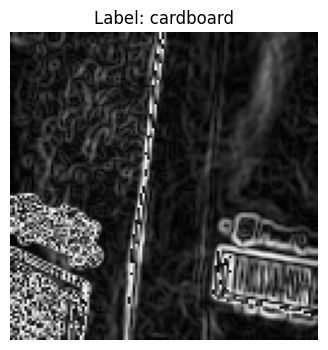

In [12]:
import matplotlib.pyplot as plt

# Show a sample image from the training set
index = 1000  # Change this to see other images
sample_image = X_train[index]

plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.title(f"Label: {le.inverse_transform([np.argmax(y_train[index])])[0]}")
plt.axis("off")
plt.show()


<Axes: >

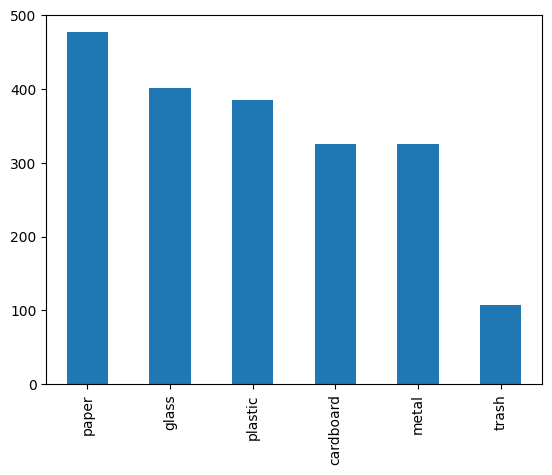

In [20]:
import pandas as pd
pd.Series(le.inverse_transform(np.argmax(y_train, axis=1))).value_counts().plot(kind='bar')


In [34]:
# Step 4: Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [45]:
# Step 5: Build model (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

In [47]:

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [48]:
# Step 6: Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2, verbose=1),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

In [49]:
# Step 7: Training
batch_size = 32
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - accuracy: 0.2620 - loss: 2.3679 - val_accuracy: 0.4684 - val_loss: 1.3464 - learning_rate: 0.0010
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.4397 - loss: 1.6300 - val_accuracy: 0.5198 - val_loss: 1.2299 - learning_rate: 0.0010
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.4801 - loss: 1.4373 - val_accuracy: 0.6008 - val_loss: 1.0982 - learning_rate: 0.0010
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.5406 - loss: 1.3004 - val_accuracy: 0.6008 - val_loss: 1.0717 - learning_rate: 0.0010
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.5363 - loss: 1.2463 - val_accuracy: 0.6146 - val_loss: 1.0286 - learning_rate: 0.0010
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.5329 - loss: 1.2625 - val_accuracy: 0.6265 - val_loss: 1.0273 - learning_rate: 0.0010
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5624 - loss: 1.1443

In [50]:
model.save("trashnet_mobilenetv2_model.h5")
print("Model saved successfully!")


Model saved successfully!


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.90      0.72      0.80        78
       glass       0.57      0.70      0.63        99
       metal       0.60      0.59      0.60        85
       paper       0.68      0.89      0.77       117
     plastic       0.60      0.47      0.53        97
       trash       0.42      0.17      0.24        30

    accuracy                           0.65       506
   macro avg       0.63      0.59      0.59       506
weighted avg       0.65      0.65      0.64       506



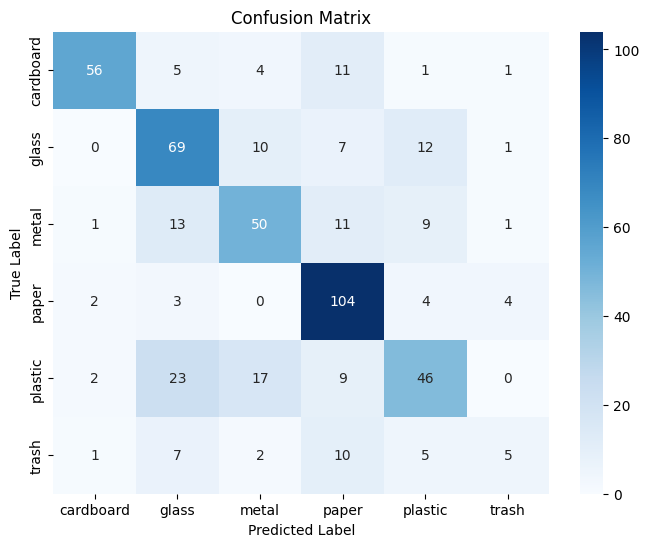

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [55]:
print(classification_report(y_true, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   cardboard       0.90      0.72      0.80        78
       glass       0.57      0.70      0.63        99
       metal       0.60      0.59      0.60        85
       paper       0.68      0.89      0.77       117
     plastic       0.60      0.47      0.53        97
       trash       0.42      0.17      0.24        30

    accuracy                           0.65       506
   macro avg       0.63      0.59      0.59       506
weighted avg       0.65      0.65      0.64       506



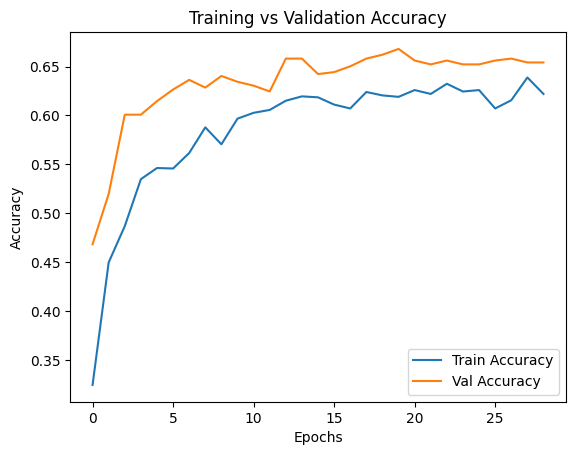

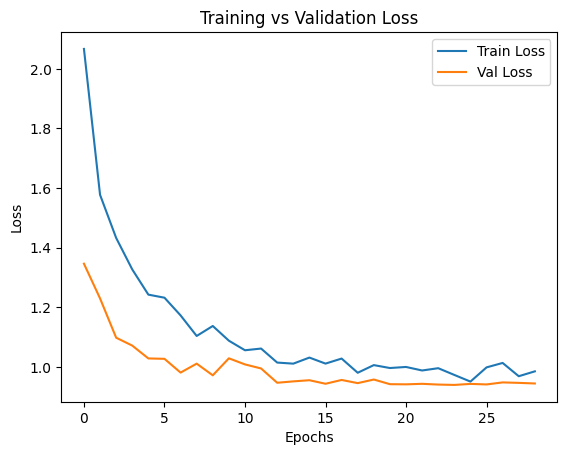

In [56]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [59]:
from PIL import Image

def predict_image(path):
    img = Image.open(path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    print(f"Predicted class: {le.inverse_transform([class_idx])[0]}")

# Example
predict_image("/content/dataset-original/glass/glass104.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted class: glass


In [61]:
predict_image("/content/download.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Predicted class: glass
